In [1]:
N = 3  # Number of analogues to each query spectrum
TEST_SLICE = -1  # set to -1 for full set

# SSMMCS parameters
SIMILARITY_THESHOLD = 0.2
NORMALIZE_WEIGHTS = True
# Morgan fingerprint parameters
MORGAN_RADIUS = 9
NBITS = 2048
USE_FEATURES = False
FPTYPE = "bv"  # "bv" (bitvector) or "count"

# FMCS parameters
TIMEOUT = 60

In [2]:
import sys
import os

# Get path to the parent directory containing the package
MAIN_FOLDER = os.path.abspath(
    os.path.join(os.getcwd(), "../ms_chemical_space_explorer")
)
DATA_FOLDER = "data"
PROCESSED_DATA_FOLDER = "processed"
FILENAME = "1000_test_spectra.mgf"
FILEPATH = os.path.join(MAIN_FOLDER, DATA_FOLDER, PROCESSED_DATA_FOLDER, FILENAME)
PICKLE = "pickle"

print(f"Adding to path: {MAIN_FOLDER}")
sys.path.append(MAIN_FOLDER)

Adding to path: g:\Dokumente\Studium\MMI\Master-Arbeit\Code\ms_chemical_space_explorer


In [3]:
from rdkit import Chem
from ms_chemical_space_explorer.fragment_extractor import (
    generate_mols_from_spectrum_query,
)
import pickle
from ms_chemical_space_explorer.chemical_space_explorer import start_workflow
from tqdm.notebook import trange, tqdm

# Chem.SetDefaultPickleProperties(Chem.PropertyPickleOptions.AllProps)

In [4]:
from typing import Callable
from rdkit.Chem.Draw import SimilarityMaps
from rdkit.Chem import rdFMCS
import pandas as pd

class MCSBenchmarkParams:
    """
    Class to hold parameters for MCS benchmarking.
    """

    def __init__(
        self, method_name: str = "mcs algorithm not defined", file_name: str = FILENAME
    ):
        self.method_name = method_name
        self.file_name = file_name

    def __str__(self) -> str:
        return f"file={self.file_name}"

    def __repr__(self) -> str:
        return self.__str__()

class SSMMCSBenchmarkParams(MCSBenchmarkParams):
    """
    Class to hold parameters for SSMMCS benchmarking.
    """

    def __init__(
        self,
        method_name: str = "SSMMCS",
        file_name: str = FILENAME,
        sim_map_threshold: float = SIMILARITY_THESHOLD,
        normalize_weigths: bool = NORMALIZE_WEIGHTS,
        fingerprint_function: str = "MORGAN",
        min_num_atoms: int = 1,
    ):
        super().__init__(method_name=method_name, file_name=file_name)
        self.fingerprint_function = fingerprint_function.upper()
        self.similarity_threshold = sim_map_threshold
        self.normalize_weights = normalize_weigths
        # MORGAN fingerprint parameters
        self.morgan_radius = MORGAN_RADIUS
        self.nbits = NBITS
        self.use_features = USE_FEATURES
        self.fp_type = FPTYPE
        self.min_num_atoms = min_num_atoms

    def __str__(self) -> str:
        return f"SSMMCS-Benchmark_threshold={self.similarity_threshold}_normalize={self.normalize_weights}_{self.get_fingerprint_params()}_{super().__str__()}"

    def __repr__(self) -> str:
        return self.__str__()

    def get_fingerprint_params(self) -> str:
        param_string = f"fp={self.fingerprint_function}"

        if self.fingerprint_function == "MORGAN":
            return f"{param_string}_r={self.morgan_radius}_type={self.fp_type}_nBits={self.nbits}_useFeatures={self.use_features}"

        return f"{param_string}"

    def get_fingerprint_function(self, mol, atom_id, **kwargs) -> Callable:
        if self.fingerprint_function == "MORGAN":
            return SimilarityMaps.GetMorganFingerprint(
                mol,
                atom_id,
                radius=self.morgan_radius,
                fpType=self.fp_type,
                nBits=self.nbits,
                useFeatures=self.use_features,
                **kwargs,
            )
        elif self.fingerprint_function == "AP":
            return SimilarityMaps.GetAPFingerprint(mol, atom_id, **kwargs)
        elif self.fingerprint_function == "TT":
            return SimilarityMaps.GetTTFingerprint(mol, atom_id, **kwargs)
        elif self.fingerprint_function == "RDK":
            return SimilarityMaps.GetRDKFingerprint(mol, atom_id, **kwargs)
        else:
            raise ValueError(
                f"Unknown fingerprint function: {self.fingerprint_function}"
            )

class FMCSBenchmarkParams(MCSBenchmarkParams):
    """
    Class to hold parameters for FMCS benchmarking.
    """

    def __init__(
        self,
        method_name: str = "FMCS",
        file_name=FILENAME,
        params: rdFMCS.MCSParameters = rdFMCS.MCSParameters(),
    ):
        super().__init__(method_name=method_name, file_name=file_name)
        self.params = params

    def __str__(self) -> str:
        atom_compare_params = self.get_atom_compare_parameters()
        bond_compare_params = self.get_bond_compare_parameters()
        base_params = self.get_base_parameters()
        return f"FMCS-Benchmark_{base_params}_{atom_compare_params}_{bond_compare_params}_{super().__str__()}"

    def __repr__(self) -> str:
        return self.__str__()

    def get_atom_compare_parameters(self) -> str:
        acp = self.params.AtomCompareParameters
        return f"ACCRO={int(acp.CompleteRingsOnly)}_ACRMRO={int(acp.RingMatchesRingOnly)}_MCT={int(acp.MatchChiralTag)}_MFC={int(acp.MatchFormalCharge)}_MI={int(acp.MatchIsotope)}_MV={int(acp.MatchValences)}_MD={acp.MaxDistance}"

    def get_bond_compare_parameters(self) -> str:
        bcp = self.params.BondCompareParameters
        return f"BCCRO={int(bcp.CompleteRingsOnly)}_BCRMRO={int(bcp.RingMatchesRingOnly)}_MFR={int(bcp.MatchFusedRings)}_MFRS={int(bcp.MatchFusedRingsStrict)}_MS={int(bcp.MatchStereo)}"

    def get_base_parameters(self) -> str:
        params = self.params
        return f"AT={int(params.AtomTyper)}_BT={int(params.BondTyper)}_TO={params.Timeout}_SA={int(params.StoreAll)}_MB={int(params.MaximizeBonds)}_TH={params.Threshold}"

class ChemSpaceExplorerBenchmarkParams:
    """
    Class to hold parameters for benchmarking on ChemSpaceExplorer results.
    """

    def __init__(
        self,
        analogues: pd.DataFrame,
        n: int = N,
        test_slice: int = TEST_SLICE,
        method_params: MCSBenchmarkParams = SSMMCSBenchmarkParams(),
    ):
        self.analogues = analogues
        self.n = n
        self.test_slice = test_slice
        self.method_params = method_params

    def __str__(self) -> str:
        if self.test_slice >= 0:
            return f"CSE_n={self.n}_slice={self.test_slice}_{self.method_params}"

        return f"CSE_n={self.n}-{self.method_params}"

    def __repr__(self) -> str:
        return self.__str__()

    def get_method_params(self):
        if self.method_params is SSMMCSBenchmarkParams:
            return SSMMCSBenchmarkParams(
                method_name=self.method_params.method_name,
                file_name=self.method_params.file_name,
                sim_map_threshold=self.method_params.sim_map_threshold,
                normalize_weigths=self.method_params.normalize_weights,
                fingerprint_function=self.method_params.fingerprint_function,
            )
        elif self.method_params is FMCSBenchmarkParams:
            return FMCSBenchmarkParams(
                method_name=self.method_params.method_name,
                file_name=self.method_params.file_name,
                params=self.method_params.params,
            )

    def get_data_slice(self, data):
        if self.test_slice >= 0:
            return data[: self.test_slice]

        return data

# Chemspace Explorer Initialization

In [5]:
from ms_chemical_space_explorer.chemical_space_explorer import spectra_importer

query_spectra = spectra_importer(FILEPATH)

Processing spectra: 100%|██████████| 1000/1000 [00:04<00:00, 246.37it/s]


In [6]:
def analogue_search(explorer, n: int = 2, epsilon: float = 0.2) -> pd.DataFrame:
    file = os.path.join(PICKLE, f"results_n={n}.pkl")
    try:
        with open(file, "rb") as f:
            analogues = pickle.load(f)
            print(f"Loaded analogues from {file}")

    except FileNotFoundError:
        analogues = explorer.analogue_search(query_spectra, n=n, epsilon=epsilon)

        with open(file, "wb") as f:
            pickle.dump(analogues, f)
        print(f"Analogues saved to {file}")

    return analogues

In [7]:
def generate_query_mols():
    file = os.path.join(PICKLE, f"{len(query_spectra)}_query_mols_for_{FILENAME}.pkl")
    query_mols = []
    try:
        with open(file, "rb") as f:
            query_mols = pickle.load(f)
            print(f"Loaded {len(query_mols)} query mols from {file}")

    except FileNotFoundError:
        for query_id, query_spectrum in tqdm(
            enumerate(query_spectra), desc="Generating query mols...", unit="mols"
        ):
            mol = Chem.MolFromSmiles(query_spectrum.metadata["smiles"])
            query_mols.append(mol)

        with open(file, "wb") as f:
            pickle.dump(query_mols, f)
        print(f"{len(query_mols)} query mols saved to {file}.")

    return query_mols


def generate_analogue_mols(dataFrame: pd.DataFrame, n=N):
    file = os.path.join(
        PICKLE,
        f"n={n}_analogue_dataframe_with_{len(query_spectra)*n}_mols_for_{FILENAME}.pkl",
    )
    try:
        with open(file, "rb") as f:
            dataFrame = pickle.load(f)
            print(f"Loaded dataframe with {len(dataFrame)} analogues from {file}")

    except FileNotFoundError:
        for idx, row in tqdm(
            dataFrame.iterrows(),
            desc="Adding mols to analogue dataframe...",
            unit="mols",
        ):
            mol = Chem.MolFromSmiles(row["smiles"])
            dataFrame.loc[idx, "mol"] = mol

        with open(file, "wb") as f:
            pickle.dump(dataFrame, f)
        print(f"Dataframe with {len(dataFrame)} analogue mols saved to {file}.")

    return dataFrame

In [8]:
if TEST_SLICE > 0:
    query_mols = generate_query_mols()[:TEST_SLICE]
else:
    query_mols = generate_query_mols()

Loaded 603 query mols from pickle\603_query_mols_for_1000_test_spectra.mgf.pkl


In [9]:
# sanity check
if TEST_SLICE > 0:
    assert len(query_mols[:TEST_SLICE]) == len(query_spectra[:TEST_SLICE])
else:
    assert len(query_mols) == len(query_spectra)

len(query_spectra) * N

1809

#### helper functions

In [10]:
def chemspace_explorer_benchmark(
    query_mols, params: ChemSpaceExplorerBenchmarkParams, method: Callable
):
    filename = f"{len(query_mols)}_results_for_{params}.csv"
    # Sanitize the whole filename again just to be safe
    filename = sanitize_filename(filename)
    file = os.path.join(DATA_FOLDER, filename)

    if os.path.exists(file):
        df = pd.read_csv(file)
        print(
            f"Loaded {len(df)} {params.method_params.method_name} results from {file}."
        )
    else:
        try:
            print(f"Running {params.method_params.method_name}...")
            df = method(query_mols, params.analogues, params.method_params, params.n)

            if len(df) == 0:
                print(f"No results for {params.method_params}.")
                return None

            # Save CSV once after all processing is complete
            os.makedirs(os.path.dirname(file), exist_ok=True)
            df.to_csv(file, index=False)
            print(
                f"Saved {len(df)} {params.method_params.method_name} results to {file}."
            )
        except Exception as e:
            print(f"Error during {params.method_params.method_name} processing: {e}")
            return None

    return df

def sanitize_filename(filename):
    """Replace invalid filename characters with underscores."""
    # Characters not allowed in Windows filenames
    invalid_chars = r'<>:"/\|?*(),'
    for char in invalid_chars:
        filename = filename.replace(char, "___")
    return filename

In [11]:
def get_query_analogues(query_id: int, analogues_df: pd.DataFrame) -> list:
    return analogues_df[analogues_df["query_spectrum_id"] == query_id]["mol"].tolist()

In [12]:
from ms_chemical_space_explorer.chemical_space_visualizer import draw_mol, draw_images
import rdkit.Chem.Draw as Draw

def draw_query_and_analogues(query_id: int, query_spectra: list[Chem.Mol], analogue_df: pd.DataFrame) -> None:
    query_analogues = analogue_df[analogue_df["query_spectrum_id"] == query_id]
    query_smiles = query_spectra[query_id].metadata["smiles"]
    query_imgs = []
    draw2d = Draw.MolDraw2DCairo(400, 400)
    query_mol = Chem.MolFromSmiles(query_smiles)
    query_imgs.append(draw_mol(draw2d, query_mol, legend=f"Query {query_id}\n{query_smiles}"))
    
    analogues = generate_mols_from_spectrum_query(spectrum_query_result=query_analogues)
    
    for i, analogue in enumerate(analogues):
        draw2d = Draw.MolDraw2DCairo(400, 400)
        query_imgs.append(draw_mol(draw2d, analogue, legend=f"Analogue {query_id}.{i}\n{query_analogues.iloc[i]['smiles']}"))
    display(draw_images(query_imgs))

# SSMMCS

In [13]:
from rdkit.Chem.Draw import SimilarityMaps

def get_stacked_sim_map_fragments_and_weights(
    mols: list[Chem.Mol],
    fp_function: Callable = SimilarityMaps.GetMorganFingerprint,
    similarity_threshold: float = SIMILARITY_THESHOLD,
    normalize_stacked_weights: bool = NORMALIZE_WEIGHTS,
) -> tuple[list[Chem.Mol], list[list[float]]]:

    stacked_weights = []
    all_analogue_fragments = []

    for ref_mol in mols:
        ref_mol_smiles = Chem.MolToSmiles(ref_mol)
        ref_mol_stacked_weights = [0] * ref_mol.GetNumAtoms()
        for probe_mol in mols:
            probe_mol_smiles = Chem.MolToSmiles(probe_mol)
            # Skip if comparing molecule to itself
            if probe_mol_smiles == ref_mol_smiles:
                continue

            # extract similarity weights for the reference molecule
            sim_weights = SimilarityMaps.GetAtomicWeightsForFingerprint(
                probe_mol, ref_mol, fp_function
            )
            sim_weights, _ = SimilarityMaps.GetStandardizedWeights(sim_weights)

            assert (
                len(sim_weights) == ref_mol.GetNumAtoms()
            ), "Length of sim_weights does not match number of atoms in reference molecule."
            # stack the weights
            ref_mol_stacked_weights = [
                ref_mol_stacked_weights[i] + sim_weights[i]
                for i in range(ref_mol.GetNumAtoms())
            ]

        if normalize_stacked_weights:
            ref_mol_stacked_weights, _ = SimilarityMaps.GetStandardizedWeights(
                ref_mol_stacked_weights
            )

        stacked_weights.append(ref_mol_stacked_weights)

        # Extract fragments from the reference molecule using the similarity weights
        analogue_fragments = extract_sim_map_fragments_from_mol(
            ref_mol, ref_mol_stacked_weights, similarity_threshold
        )
        all_analogue_fragments.extend(analogue_fragments)

    return all_analogue_fragments, stacked_weights

def find_SSMMCS_and_SSMMSS(
    mols: list[Chem.Mol], substruct_candidates: list[Chem.Mol], min_num_atoms: int = 1
) -> tuple[Chem.Mol | None, Chem.Mol | None]:

    common_substructs = []
    unique_smiles = set()
    mcs_id = -1
    mcs_size = 0
    mss = None
    mss_size = 0

    for substruct in substruct_candidates:
        num_Atoms = substruct.GetNumAtoms()

        # skip substructs below atom threshold
        if num_Atoms < min_num_atoms:
            continue

        # skip duplicates
        smiles = Chem.MolToSmiles(substruct)
        if smiles in unique_smiles:
            continue
        unique_smiles.add(smiles)

        # find the maximum stacked substructure (MSS)
        if num_Atoms > mss_size:
            mss = substruct
            mss_size = num_Atoms

        # find the maximum common substructure (MCS)
        is_common = True
        for analogue in mols:
            if len(analogue.GetSubstructMatch(substruct)) <= 0:
                is_common = False
                break

        if not is_common:
            continue
        common_substructs.append(substruct)

        if num_Atoms > mcs_size:
            mcs_id = len(common_substructs) - 1
            mcs_size = num_Atoms

        # if MSS and MCS are the same size, update MSS to MCS
        if num_Atoms == mss_size:
            mss = common_substructs[mcs_id]

    if mcs_id < 0:
        mcs = None
    else:
        mcs = common_substructs[mcs_id]

    return mcs, mss

def extract_sim_map_fragments_from_mol(
    mol: Chem.Mol, similarity_weights: list[float], similarity_threshold: float
) -> list[Chem.Mol]:

    visited = set()
    fragment_mols = []

    # Iterate through all atoms to find connected_atoms
    for atom in mol.GetAtoms():
        atom_idx = atom.GetIdx()
        if (
            atom_idx not in visited
            and similarity_weights[atom_idx] >= similarity_threshold
        ):
            connected_atoms = find_connected_atoms_recursive(
                atom_idx, visited, mol, similarity_weights, similarity_threshold
            )
            if connected_atoms:
                # Create a new molecule for this connected_atoms
                fragment = Chem.RWMol(mol)

                # Create a map of atoms to remove (those not in connected_atoms)
                atoms_to_remove = set(range(mol.GetNumAtoms())) - connected_atoms

                # Remove atoms not in connected_atoms (remove in reverse order to preserve indices)
                for remove_idx in sorted(atoms_to_remove, reverse=True):
                    fragment.RemoveAtom(remove_idx)

                # Convert to regular molecule and add to list
                fragment_mols.append(fragment.GetMol())

    return fragment_mols

def find_connected_atoms_recursive(
    atom_idx: int,
    visited: set[int],
    mol: Chem.Mol,
    similarity_weights: list[float],
    similarity_threshold: float,
) -> set[int]:
    if atom_idx in visited or similarity_weights[atom_idx] < similarity_threshold:
        return set()

    atoms = {atom_idx}
    visited.add(atom_idx)

    # Get current atom object
    atom = mol.GetAtomWithIdx(atom_idx)

    # Iterate through bonds to neighboring atoms
    for bond in atom.GetBonds():
        # Get the neighboring atom's index
        neighbor_idx = (
            bond.GetBeginAtomIdx()
            if bond.GetEndAtomIdx() == atom_idx
            else bond.GetEndAtomIdx()
        )

        if similarity_weights[neighbor_idx] >= similarity_threshold:
            atoms.update(
                find_connected_atoms_recursive(
                    neighbor_idx, visited, mol, similarity_weights, similarity_threshold
                )
            )

    return atoms

def score_stacked_weights_against_query(query: Chem.Mol, analogues: list[Chem.Mol], stacked_weights: list[list[float]], fp_fuction: Callable, normalize_weights: bool
                                        )-> tuple[float, list[float]]: 
    analogue_weight_differences = []
    for i, analogue in enumerate(analogues):
        assert (len(stacked_weights[i]) == analogue.GetNumAtoms()), f"Length of stacked_weights {i} does not match number of atoms in analogue {i}."
        
        query_weights = SimilarityMaps.GetAtomicWeightsForFingerprint(query, analogue, fp_fuction)
        if(normalize_weights):
            query_weights, _ = SimilarityMaps.GetStandardizedWeights(query_weights)

        atom_weight_differences = [abs(stacked_weights[i][j] - query_weights[j]) for j in range(len(stacked_weights[i]))] # calculate a list of weight differences for each atom
        analogue_weight_differences.append(sum(atom_weight_differences) / len(atom_weight_differences)) # average of all atom weight differences
    
    query_weight_difference = sum(analogue_weight_differences) / len(analogue_weight_differences)
    
    return query_weight_difference, analogue_weight_differences

In [ ]:
import time

def benchmark_ssmmcs(query_mols, analogues: pd.DataFrame, ssmmcs_params: SSMMCSBenchmarkParams, n: int = N) -> pd.DataFrame:
    ssmmcs_df = pd.DataFrame()

    for query_id, query_mol in tqdm(
        enumerate(query_mols), total=len(query_mols), desc=f"SSMMCS with n={n}"
    ):
        try:
            query_analogues = get_query_analogues(query_id, analogues)
            if len(query_analogues) < 2:
                print(
                    f"Skipping query {query_id} due to insufficient number of analogues!"
                )
                continue
            
            # calculate ssmmcs and ssmss
            start_time = time.time()
            all_analogue_fragments, stacked_weigths = get_stacked_sim_map_fragments_and_weights(mols=query_analogues,
                                                                                                fp_function=ssmmcs_params.get_fingerprint_function,
                                                                                                similarity_threshold=ssmmcs_params.similarity_threshold,
                                                                                                normalize_stacked_weights=ssmmcs_params.normalize_weights,
                                                                                                )
            mcs, mss = find_SSMMCS_and_SSMMSS(query_analogues, all_analogue_fragments, min_num_atoms=ssmmcs_params.min_num_atoms)
            elapsed_time = time.time() - start_time
            
            # gather data
            if mcs is None:
                mcs_matched_query = False
                mcs_size = 0
                mcs_size_relative = 0
                query_match_mcs = None
                mcs_smarts = ""
            else:
                query_match_mcs = query_mol.GetSubstructMatch(mcs)
                mcs_matched_query = len(query_match_mcs) > 0
                mcs_size = mcs.GetNumAtoms()
                mcs_size_relative = mcs_size / query_mol.GetNumAtoms()
                mcs_smarts = Chem.MolToSmarts(mcs)

            if mss is None:
                mss_matched_query = False
                mss_size = 0
                mss_size_relative = 0
                query_match_mss = None
                mss_smarts = ""
            else:
                query_match_mss = query_mol.GetSubstructMatch(mss)
                mss_matched_query = len(query_match_mss) > 0
                mss_size = mss.GetNumAtoms()
                mss_size_relative = mss_size / query_mol.GetNumAtoms()
                mss_smarts = Chem.MolToSmarts(mss)
            
            # check the quality of the stacked similarity weights against the actual query similarity weights
            query_weight_diff, analogue_weight_diffs = score_stacked_weights_against_query(
                query_mol, query_analogues, stacked_weigths, ssmmcs_params.get_fingerprint_function, ssmmcs_params.normalize_weights)

            # Save data as a row
            new_row = {
                "query_id": query_id,
                "mcs_matched_query": mcs_matched_query, # boolean
                "mss_matched_query": mss_matched_query,
                "failed": not mcs_matched_query and not mss_matched_query,
                "time": elapsed_time,
                "mcs_size": mcs_size,
                "mcs_size_relative": mcs_size_relative,
                "mcs_smarts": mcs_smarts,
                "mss_size": mss_size,
                "mss_size_relative": mss_size_relative,
                "mss_smarts": mss_smarts,
                "query_match_mcs": query_match_mcs,     # list of query atom indices
                "query_match_mss": query_match_mss,
                "query_weight_diff": query_weight_diff, # average of all analogue weight differences
                "analogue_weight_diffs": analogue_weight_diffs, # list of average weight differences for each analogue
                "stacked_weights": stacked_weigths, # list of stacked weights for each analogue
            }
            ssmmcs_df = pd.concat(
                [ssmmcs_df, pd.DataFrame([new_row])], ignore_index=True
            )
        except Exception as e:
            print(f"Error processing query {query_id}: {e}")
            continue

    return ssmmcs_df

In [15]:
ssmmcs_params = SSMMCSBenchmarkParams(
    method_name="SSMMCS",
    file_name=FILENAME,
    sim_map_threshold=SIMILARITY_THESHOLD,
    normalize_weigths=NORMALIZE_WEIGHTS,
    fingerprint_function="morgan",
)

explorer = start_workflow(os.path.abspath(os.path.join(MAIN_FOLDER, DATA_FOLDER, PROCESSED_DATA_FOLDER)))

Initialize ChemExplorer


d:\Programmierung\anaconda3\envs\chemspace\Lib\site-packages\ms2deepscore\models\load_model.py:34: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_settings = torch.load(

In [16]:
# create a dict with int keys and dataframes as values
benchmark_results = {}

for n in tqdm(range(2, 16), desc="Benchmarking"):
    n_analogues = analogue_search(explorer=explorer, n=n)
    n_analogues = generate_analogue_mols(n_analogues, n=n)

    cse = ChemSpaceExplorerBenchmarkParams(n=n, analogues=n_analogues, method_params=ssmmcs_params)

    benchmark_results[n] = chemspace_explorer_benchmark(query_mols, params=cse, method=benchmark_ssmmcs)

Benchmarking:   0%|          | 0/14 [00:00<?, ?it/s]

Loaded analogues from pickle\results_n=2.pkl
Loaded dataframe with 1205 analogues from pickle\n=2_analogue_dataframe_with_1206_mols_for_1000_test_spectra.mgf.pkl
Loaded 602 SSMMCS results from data\603_results_for_CSE_n=2-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.
Loaded analogues from pickle\results_n=3.pkl
Loaded dataframe with 1806 analogues from pickle\n=3_analogue_dataframe_with_1809_mols_for_1000_test_spectra.mgf.pkl
Loaded 602 SSMMCS results from data\603_results_for_CSE_n=3-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.
Loaded analogues from pickle\results_n=4.pkl
Loaded dataframe with 2404 analogues from pickle\n=4_analogue_dataframe_with_2412_mols_for_1000_test_spectra.mgf.pkl
Loaded 602 SSMMCS results from data\603_results_for_CSE_n=4-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=20

SSMMCS with n=5:   0%|          | 0/603 [00:00<?, ?it/s]

Skipping query 564 due to insufficient number of analogues!
Saved 602 SSMMCS results to data\603_results_for_CSE_n=5-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.
Loaded analogues from pickle\results_n=6.pkl
Loaded dataframe with 3597 analogues from pickle\n=6_analogue_dataframe_with_3618_mols_for_1000_test_spectra.mgf.pkl
Running SSMMCS...


SSMMCS with n=6:   0%|          | 0/603 [00:00<?, ?it/s]

Skipping query 564 due to insufficient number of analogues!
Saved 602 SSMMCS results to data\603_results_for_CSE_n=6-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.
Loaded analogues from pickle\results_n=7.pkl
Loaded dataframe with 4189 analogues from pickle\n=7_analogue_dataframe_with_4221_mols_for_1000_test_spectra.mgf.pkl
Running SSMMCS...


SSMMCS with n=7:   0%|          | 0/603 [00:00<?, ?it/s]

Skipping query 564 due to insufficient number of analogues!
Saved 602 SSMMCS results to data\603_results_for_CSE_n=7-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.
Loaded analogues from pickle\results_n=8.pkl
Loaded dataframe with 4773 analogues from pickle\n=8_analogue_dataframe_with_4824_mols_for_1000_test_spectra.mgf.pkl
Running SSMMCS...


SSMMCS with n=8:   0%|          | 0/603 [00:00<?, ?it/s]

Skipping query 564 due to insufficient number of analogues!
Saved 602 SSMMCS results to data\603_results_for_CSE_n=8-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.
Loaded analogues from pickle\results_n=9.pkl
Loaded dataframe with 5352 analogues from pickle\n=9_analogue_dataframe_with_5427_mols_for_1000_test_spectra.mgf.pkl
Running SSMMCS...


SSMMCS with n=9:   0%|          | 0/603 [00:00<?, ?it/s]

Skipping query 564 due to insufficient number of analogues!
Saved 602 SSMMCS results to data\603_results_for_CSE_n=9-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.
Loaded analogues from pickle\results_n=10.pkl
Loaded dataframe with 5914 analogues from pickle\n=10_analogue_dataframe_with_6030_mols_for_1000_test_spectra.mgf.pkl
Running SSMMCS...


SSMMCS with n=10:   0%|          | 0/603 [00:00<?, ?it/s]

Skipping query 564 due to insufficient number of analogues!
Saved 602 SSMMCS results to data\603_results_for_CSE_n=10-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.
Loaded analogues from pickle\results_n=11.pkl
Loaded dataframe with 6504 analogues from pickle\n=11_analogue_dataframe_with_6633_mols_for_1000_test_spectra.mgf.pkl
Running SSMMCS...


SSMMCS with n=11:   0%|          | 0/603 [00:00<?, ?it/s]

Skipping query 564 due to insufficient number of analogues!
Saved 602 SSMMCS results to data\603_results_for_CSE_n=11-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.
Loaded analogues from pickle\results_n=12.pkl
Loaded dataframe with 7091 analogues from pickle\n=12_analogue_dataframe_with_7236_mols_for_1000_test_spectra.mgf.pkl
Running SSMMCS...


SSMMCS with n=12:   0%|          | 0/603 [00:00<?, ?it/s]

Saved 603 SSMMCS results to data\603_results_for_CSE_n=12-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.
Loaded analogues from pickle\results_n=13.pkl
Loaded dataframe with 7678 analogues from pickle\n=13_analogue_dataframe_with_7839_mols_for_1000_test_spectra.mgf.pkl
Running SSMMCS...


SSMMCS with n=13:   0%|          | 0/603 [00:00<?, ?it/s]

Saved 603 SSMMCS results to data\603_results_for_CSE_n=13-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.
Loaded analogues from pickle\results_n=14.pkl
Loaded dataframe with 8270 analogues from pickle\n=14_analogue_dataframe_with_8442_mols_for_1000_test_spectra.mgf.pkl
Running SSMMCS...


SSMMCS with n=14:   0%|          | 0/603 [00:00<?, ?it/s]

Saved 603 SSMMCS results to data\603_results_for_CSE_n=14-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.
Loaded analogues from pickle\results_n=15.pkl
Loaded dataframe with 8861 analogues from pickle\n=15_analogue_dataframe_with_9045_mols_for_1000_test_spectra.mgf.pkl
Running SSMMCS...


SSMMCS with n=15:   0%|          | 0/603 [00:00<?, ?it/s]

Saved 603 SSMMCS results to data\603_results_for_CSE_n=15-SSMMCS-Benchmark_threshold=0.2_normalize=True_fp=MORGAN_r=9_type=bv_nBits=2048_useFeatures=False_file=1000_test_spectra.mgf.csv.


In [ ]:
for n in tqdm([20, 30, 50], desc="Benchmarking"):
    n_analogues = analogue_search(explorer=explorer, n=n)
    n_analogues = generate_analogue_mols(n_analogues, n=n)

    cse = ChemSpaceExplorerBenchmarkParams(n=n, analogues=n_analogues, method_params=ssmmcs_params)

    benchmark_results[n] = chemspace_explorer_benchmark(query_mols, params=cse, method=benchmark_ssmmcs)

Benchmarking:   0%|          | 0/3 [00:00<?, ?it/s]

603it [00:01, 452.09it/s]
d:\Programmierung\anaconda3\envs\chemspace\Lib\site-packages\matchms\similarity\vector_similarity_functions.py:31: RuntimeWarning: invalid value encountered in divide
  jaccard = np.nan_to_num(intersection / union)  # R,Q


Discarded 256 positive ionmode analogues without reference compound.
Discarded 0 negative ionmode analogues without reference compound.
Analogues saved to pickle\results_n=20.pkl


Adding mols to analogue dataframe...: 0mols [00:00, ?mols/s]

Dataframe with 11804 analogue mols saved to pickle\n=20_analogue_dataframe_with_12060_mols_for_1000_test_spectra.mgf.pkl.
Running SSMMCS...


SSMMCS with n=20:   0%|          | 0/603 [00:00<?, ?it/s]

In [ ]:
benchmark_results[50].head()

,query_id,mcs_matched_query,mss_matched_query,failed,time,mcs_size,mcs_smarts,mss_size,mss_smarts,query_match_mcs,query_match_mss,query_weight_diff,analogue_weight_diffs,stacked_weights
0,0,True,True,False,0.059999,45,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,45,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[...,"(7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...","(7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, ...",0.002808,"[0.0, 0.0056161160268515895]","[[0.12516469038208172, 0.18153294486777227, 0...."
1,1,True,True,False,0.039003,31,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6](=...,31,[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6]-[#6](=...,"(41, 40, 39, 38, 37, 36, 35, 34, 32, 33, 31, 3...","(41, 40, 39, 38, 37, 36, 35, 34, 32, 33, 31, 3...",0.107366,"[0.12103721221741302, 0.09369568507231558]","[[-0.10559616023203956, 0.08629292398200983, 0..."
2,2,True,True,False,0.017997,9,[#8](-[#6@@H]-[#6@H](-[#8]-[#6])-[#8])-[#6](-[...,9,[#8](-[#6@@H]-[#6@H](-[#8]-[#6])-[#8])-[#6](-[...,"(4, 3, 1, 2, 0, 16, 15, 9, 17)","(4, 3, 1, 2, 0, 16, 15, 9, 17)",0.383040,"[0.26605169982945354, 0.5000274888006142]","[[0.4517845340383348, 0.6584360690383946, 0.73..."
3,3,True,True,False,0.021002,20,[#6]1:[#6]:[#6](-[#8]):[#6]2:[#6](:[#6]:1)-[#8...,20,[#6]1:[#6]:[#6](-[#8]):[#6]2:[#6](:[#6]:1)-[#8...,"(7, 6, 4, 5, 3, 10, 9, 11, 12, 13, 20, 19, 17,...","(7, 6, 4, 5, 3, 10, 9, 11, 12, 13, 20, 19, 17,...",0.199040,"[0.19569049897199553, 0.20238911464634476]","[[-0.010929421554053425, -0.17535459946490367,..."
4,4,False,False,True,0.009000,11,[#6]-[#6]1-[#6](-[#6])(-[#6](=[#8])-[#8])-[#6]...,11,[#6]-[#6]1-[#6](-[#6])(-[#6](=[#8])-[#8])-[#6]...,(),(),0.683304,"[0.7352390184117134, 0.6313689845031237]","[[0.04044444444444427, -0.07824074074074082, -..."


# Benchmark results

In [53]:
weight_diff_benchmark_df = pd.DataFrame()

for n, df in benchmark_results.items():
    df_row = pd.DataFrame()
    
    row_dict = {
            "n": n,
            "mean": df["query_weight_diff"].mean(),
            "max": df["query_weight_diff"].max(),
            "min": df["query_weight_diff"].min(),
            "std": df["query_weight_diff"].std(),
            "median": df["query_weight_diff"].median(),
            "time": df["time"].sum(),
            "time_mean": df["time"].mean(),
        }
        
    weight_diff_benchmark_df = pd.concat([weight_diff_benchmark_df, pd.DataFrame([row_dict])], ignore_index=True)

In [54]:
weight_diff_benchmark_df

,n,mean,max,min,std,median,time,time_mean
0,2,0.463298,1.022661,0.002808,0.188211,0.464840,12.451056,0.020683
1,3,0.424016,1.014413,0.022741,0.164669,0.420323,35.685101,0.059278
2,4,0.401635,0.922193,0.024515,0.152877,0.394336,71.373088,0.118560
3,5,0.384882,0.901204,0.020552,0.141460,0.374840,115.789365,0.192341
4,6,0.375625,0.903133,0.017372,0.133107,0.376875,171.773227,0.285338
5,7,0.368256,0.895468,0.016002,0.125860,0.360908,237.870953,0.395134
6,8,0.361958,0.776417,0.035764,0.118168,0.359743,314.316078,0.522120
7,9,0.358299,0.695451,0.037642,0.109498,0.360253,401.689127,0.667258
8,10,0.355632,0.699275,0.037789,0.107141,0.351268,498.197800,0.827571
9,11,0.354943,0.729147,0.036718,0.106181,0.348665,602.935076,1.001553


## Plots

<Figure size 1000x400 with 0 Axes>

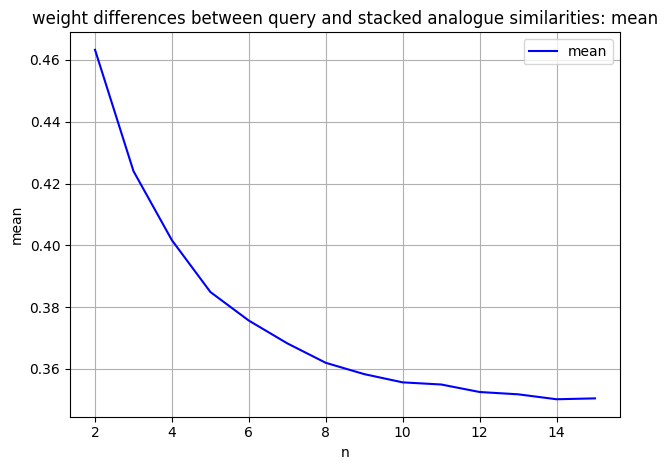

<Figure size 1000x400 with 0 Axes>

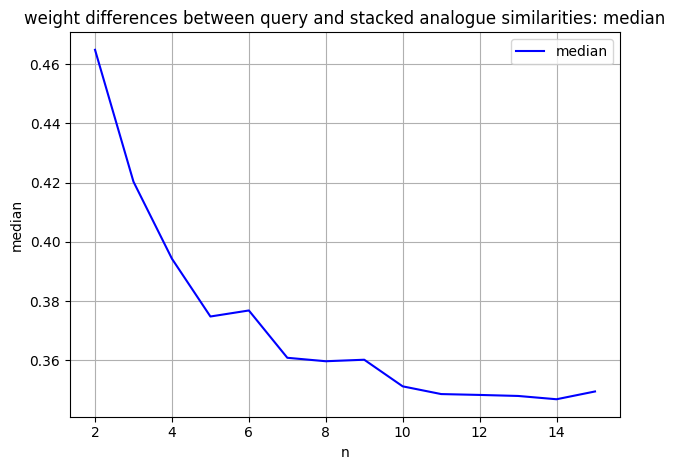

<Figure size 1000x400 with 0 Axes>

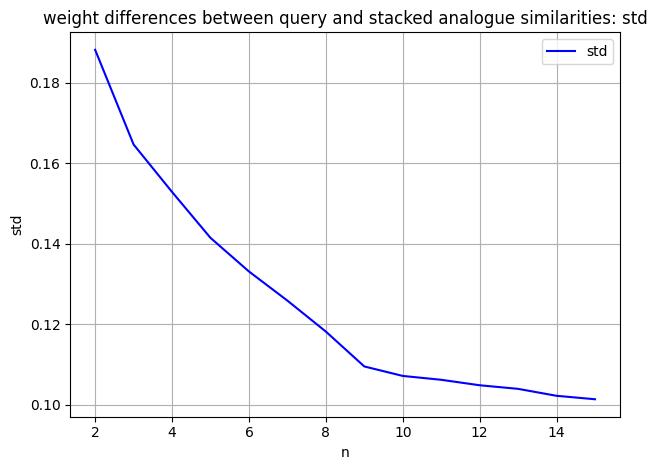

In [55]:
import matplotlib.pyplot as plt

for column in ["mean", "median", "std"]:
    plt.figure(figsize=(10, 4))
    weight_diff_benchmark_df.plot(x='n', y=column, xlabel="n", ylabel=column, 
                                 legend=True, grid=True, color="blue")
    plt.title(f"weight differences between query and stacked analogue similarities: {column}")
    plt.tight_layout()
    plt.show()